<div class="alert alert-block alert-info">
<center> <h1> BUSINESS CASES FOR DATA SCIENCE</h1> </center> <br>
<center> BC4: Cryptocurrency Value Prediction 2021/2022 </center>

**GROUP AC:**    <br> 
- Beatriz Neto (20210608) <br>
- Rodrigo Joaquim (20211024) <br>
- Sara Silva (20210619)

**Table of Contents** <hr>
* [1. Import](#import)
    * [1.1. Import Libraries](#importlibraries)
    * [1.2. Import Dataset](#importdatasets)
* [2.Data Preparation](#datapreparation) 
* [3.Data Engineering](#dataeng)
* [4..Exploratory Analysis](#exploratory)
    * [4.1.Market Cap and Volume Visualization](#market_volume)
    * [4.2.Tendency](#tendency)
    * [4.3. HeatMap for each Coin](#heatmap_coin)
    * [4.4.HeatMap for Bitcoin Variables](#heatmap_variables)
    * [4.5.% Change Visualization](#per_change)
    * [4.6.Stationarity for BTC](#stationarity_btc)
    * [4.7.Indicators analysis for bitcoin](#indicators_btc)   
* [5..Models (trial Bitcoin only)](#models)
    * [5.1.XGBoost](#xgboost)
    * [5.2.LSTM](#lstm)
    * [5.3. BiLSTM](#bilstm)
    * [5.4.GRU](#gru)
    * [5.5.Support Vector Machine](#svm)
* [6. Models (generalization)](#modelgen)
* [7. Predicting close price for May 10th 2022](#predict)

<hr>
<a class="anchor" id="import">
    
# 1. Imports
    
</a>

<a class="anchor" id="importlibraries">

## 1.1. Import Libraries

</a>

In [1]:

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

import seaborn as sns

!pip install pandas_ta
import pandas_ta as ta

import ta

!pip install cryptocmd
from cryptocmd import CmcScraper


from pylab import rcParams
from plotly.subplots import make_subplots



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR

from statsmodels.tsa.seasonal import seasonal_decompose


!pip install tensorflow
import tensorflow as tf
tf.random.set_seed(93)

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, Bidirectional, GRU, TimeDistributed
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from itertools import cycle

! pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score




<a class="anchor" id="importdatasets">

## 1.2. Import Datasets

</a>

In [2]:
path = 'https://raw.githubusercontent.com/joaopfonseca/business-cases-21-22/main/BC4_crypto_forecasting/data/'

adj_close = pd.read_csv(path + 'adj_close.csv')
close = pd.read_csv(path + 'close.csv')
high = pd.read_csv(path + 'high.csv')
low = pd.read_csv(path + 'low.csv')
open_ = pd.read_csv(path + 'open.csv')
volume = pd.read_csv(path + 'volume.csv')

In [3]:
# it makes more sense to have a dataframe for each cryptocurrency with close, high, etc as columns
# instead of working with data how it was originally provided

def create_crypto_df(crypto):
    
    name = [close['Date'], close[crypto], adj_close[crypto], high[crypto], 
            low[crypto], open_[crypto], volume[crypto]]

    df = pd.concat(name, axis = 1).set_index('Date').dropna()

    df.columns = ['close', 'adj_close', 'high', 'low', 'open', 'volume']
    
    return df

In [4]:
# creation of the dataframes for each cryptocurrency

ADA = create_crypto_df('ADA-USD')
BTC = create_crypto_df('BTC-USD')
ATOM = create_crypto_df('ATOM-USD')
AVAX = create_crypto_df('AVAX-USD')
AXS = create_crypto_df('AXS-USD')
ETH = create_crypto_df('ETH-USD')
LINK = create_crypto_df('LINK-USD')
LUNA1 = create_crypto_df('LUNA1-USD')
MATIC = create_crypto_df('MATIC-USD')
SOL = create_crypto_df('SOL-USD')

<hr>
<a class="anchor" id="datapreparation">
    
# 2. Data Preparation
    
</a>

In [5]:
# Avalanche has data in two dates of July 2020 when the initial release was in September 2020
# so those two rows are going to be removed

AVAX = AVAX.loc['2020-09-22':]

In [6]:
# we're only going to use the last 366 in order to don't have bad influence of the older data on our predictions


ADA = ADA.iloc[-366:]
BTC = BTC.iloc[-366:]
ATOM = ATOM.iloc[-366:]
AVAX = AVAX.iloc[-366:]
AXS = AXS.iloc[-366:]
ETH = ETH.iloc[-366:]
LINK = LINK.iloc[-366:]
LUNA1 = LUNA1.iloc[-366:]
MATIC = MATIC.iloc[-366:]
SOL = SOL.iloc[-366:]

In [7]:
# remove adj_close feature since it has the same values that close

ADA.drop('adj_close', axis=1, inplace = True)
BTC.drop('adj_close', axis=1, inplace = True)
ATOM.drop('adj_close', axis=1, inplace = True)
AVAX.drop('adj_close', axis=1, inplace = True)
AXS.drop('adj_close', axis=1, inplace = True)
ETH.drop('adj_close', axis=1, inplace = True)
LINK.drop('adj_close', axis=1, inplace = True)
LUNA1.drop('adj_close', axis=1, inplace = True)
MATIC.drop('adj_close', axis=1, inplace = True)
SOL.drop('adj_close', axis=1, inplace = True)

<hr>
<a class="anchor" id="dataengineering">
    
# 3. Data Engineering
    
</a>

In [8]:
#implmenting the variable Market Cap for each crypto dataframe

def implementing_Market_Cap_variable(dataframe, crypto):
    
    dataframe = dataframe.reset_index()

    #changing datatype
    dataframe['Date'] = pd.to_datetime(dataframe['Date'], errors='coerce')
    
    
    # initialise scraper without time interval for max historical data
    dataframe['Date'] = dataframe['Date'].dt.strftime('%d-%m-%Y')
    
    
    scraper = CmcScraper(crypto)

    #defining an interval
    scraper = CmcScraper(crypto, dataframe['Date'][0] , dataframe['Date'].tail(1).values[0])

    df = scraper.get_dataframe()
    
    df = df.sort_values(by='Date')

    #creating a list for the new variable
    list_ = list(df['Market Cap'])
    print(list)

    #implementing the new variable in the dataset that we're going to work
    dataframe['Market Cap'] = list_

   
    return dataframe

In [9]:
#Assigning asset_id as well
BTC = implementing_Market_Cap_variable(BTC, 'BTC').assign(Asset_ID='BTC')
LUNA1 = implementing_Market_Cap_variable(LUNA1, 'LUNA').assign(Asset_ID='LUNA1')
ADA = implementing_Market_Cap_variable(ADA, 'ADA').assign(Asset_ID='ADA')
ATOM = implementing_Market_Cap_variable(ATOM, 'ATOM').assign(Asset_ID='ATOM')
AVAX = implementing_Market_Cap_variable(AVAX, 'AVAX').assign(Asset_ID='AVAX')
AXS = implementing_Market_Cap_variable(AXS, 'AXS').assign(Asset_ID='AXS')
ETH = implementing_Market_Cap_variable(ETH, 'ETH').assign(Asset_ID='ETH')
LINK = implementing_Market_Cap_variable(LINK, 'LINK').assign(Asset_ID='LINK')
MATIC = implementing_Market_Cap_variable(MATIC, 'MATIC').assign(Asset_ID='MATIC')
SOL = implementing_Market_Cap_variable(SOL, 'SOL').assign(Asset_ID='SOL')

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [10]:
# define function to compute log returns

#Log returns
#In order to analyze price changes for an asset we can deal with the price difference. 

#However, different assets exhibit different price scales, so that the their returns are not readily 
#comparable. We can solve this problem by computing the percentage change in price instead, also known as the return.

#This return coincides with the percentage change in our invested capital.

#Returns are widely used in finance, however log returns are preferred for mathematical modelling of time series, 
#as they are additive across time. Also, while regular returns cannot go below -100%, log returns are not bounded.

#To compute the log return, we can simply take the logarithm of the ratio between two consecutive close prices. 
#The first row will have an empty return as the previous value is unknown, therefore the empty
#return data point will be dropped.

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

BTC['%Change']=log_return(BTC.close)[1:]
ETH['%Change']=log_return(ETH.close)[1:]
ADA['%Change']=log_return(ADA.close)[1:]
LUNA1['%Change']=log_return(LUNA1.close)[1:]
AVAX['%Change']=log_return(AVAX.close)[1:]
LINK['%Change']=log_return(LINK.close)[1:]
MATIC['%Change']=log_return(MATIC.close)[1:]
ATOM['%Change']=log_return(ATOM.close)[1:]
AXS['%Change']=log_return(AXS.close)[1:]
SOL['%Change']=log_return(SOL.close)[1:]

##creating the Moving Average % Change 
BTC["%Change_MA"] = ta.volatility.bollinger_mavg(BTC["%Change"])
ETH["%Change_MA"] = ta.volatility.bollinger_mavg(ETH["%Change"])
ADA["%Change_MA"] = ta.volatility.bollinger_mavg(ADA["%Change"])
LUNA1["%Change_MA"] = ta.volatility.bollinger_mavg(LUNA1["%Change"])
AVAX["%Change_MA"] = ta.volatility.bollinger_mavg(AVAX["%Change"])
LINK["%Change_MA"] = ta.volatility.bollinger_mavg(LINK["%Change"])
MATIC["%Change_MA"] = ta.volatility.bollinger_mavg(MATIC["%Change"])
ATOM["%Change_MA"] = ta.volatility.bollinger_mavg(ATOM["%Change"])
AXS["%Change_MA"] = ta.volatility.bollinger_mavg(AXS["%Change"])
SOL["%Change_MA"] = ta.volatility.bollinger_mavg(SOL["%Change"])

                                                 
#dropping the column %Change for each dataframe
BTC.drop('%Change', axis=1, inplace=True)
ETH.drop('%Change', axis=1, inplace=True)
ADA.drop('%Change', axis=1, inplace=True)
LUNA1.drop('%Change', axis=1, inplace=True)
AVAX.drop('%Change', axis=1, inplace=True)     
LINK.drop('%Change', axis=1, inplace=True)
MATIC.drop('%Change', axis=1, inplace=True)
ATOM.drop('%Change', axis=1, inplace=True)
AXS.drop('%Change', axis=1, inplace=True)
SOL.drop('%Change', axis=1, inplace=True)

### Creating indicators variables for bitcoin

In [11]:
BTC_ind= BTC.copy()

In [12]:
# creating rsi feature
BTC_ind["rsi"] = ta.momentum.rsi(BTC_ind["close"], window=14, fillna=False)

# creating MACD Line, signal and histogram
BTC_ind.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

# creating bollinger band high indicator filling nans values
BTC_ind["bb_high_band"] = ta.volatility.bollinger_hband(
    BTC_ind["close"]
)

# creating bollinger band low indicator filling nans values
BTC_ind["bb_low_band"] = ta.volatility.bollinger_lband(
    BTC_ind["close"]
)

#Bollinger Channel Middle Band
BTC_ind["bb_middle_band"] = ta.volatility.bollinger_mavg(
    BTC_ind["close"]
)

#creating On-balance volume (OBV)
BTC_ind["obv"] = ta.volume.on_balance_volume(BTC_ind["close"], BTC_ind['volume'])

<hr>
<a class="anchor" id="exploratory">
    
# 4. Exploratoy Analysis
    
</a>

### merging all coins in 1 dataframe

In [13]:
all__data = pd.concat([ADA, BTC, ATOM,AVAX, AXS, ETH, LINK, LUNA1, MATIC, SOL])

In [14]:
# visualizing the new column Asset_ID
all__data.head()

Date     close      high       low      open        volume  \
0  25-04-2021  1.088250  1.146124  1.022775  1.102703  2.465672e+09   
1  26-04-2021  1.234019  1.249876  1.082105  1.090186  3.201087e+09   
2  27-04-2021  1.306927  1.329766  1.224979  1.237595  2.985493e+09   
3  28-04-2021  1.335666  1.348198  1.235215  1.305966  2.981477e+09   
4  29-04-2021  1.308014  1.410331  1.267940  1.337107  3.997566e+09   

     Market Cap Asset_ID  %Change_MA  
0  3.476776e+10      ADA         NaN  
1  3.942484e+10      ADA         NaN  
2  4.175411e+10      ADA         NaN  
3  4.267227e+10      ADA         NaN  
4  4.178883e+10      ADA         NaN

<hr>
<a class="anchor" id="market_volume">
    
# 4.1. Market Cap and Volume Visualization
    
</a>

In [15]:
#Sort cryptos by volume
all_data=all__data.sort_values(by='volume', ascending=False)

<ipython-input-16-c4adb55b6c9e>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks())


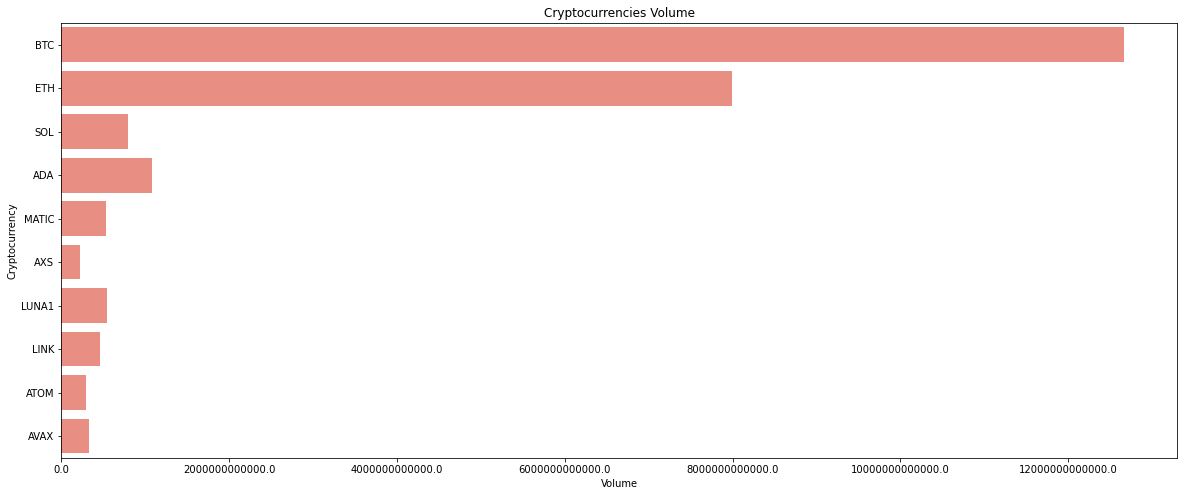

In [16]:
# Plotting cryptos by volume to decide which will be in the indicators
x=10
name = all_data['Asset_ID'].unique()
currency  = []
volume = []
x_currencies = name[:x]
for i, cn in enumerate(x_currencies):
    filtered = all_data[(all_data['Asset_ID']==str(cn))]
    currency.append(str(cn))
    volume.append(filtered['volume'].sum())
        
f, ax = plt.subplots(figsize=(20, 8)) 
g = sns.barplot( y = currency, x = volume, color='salmon')
plt.title("Cryptocurrencies Volume")
plt.xlabel('Volume')
plt.ylabel('Cryptocurrency')
ax.set_xticklabels(ax.get_xticks())
fig=plt.gcf()
plt.show()

In [17]:
#Sort cryptos by volume
all_data=all_data.sort_values(by='Market Cap', ascending=False)

<ipython-input-18-b8f1b4aad38c>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks())


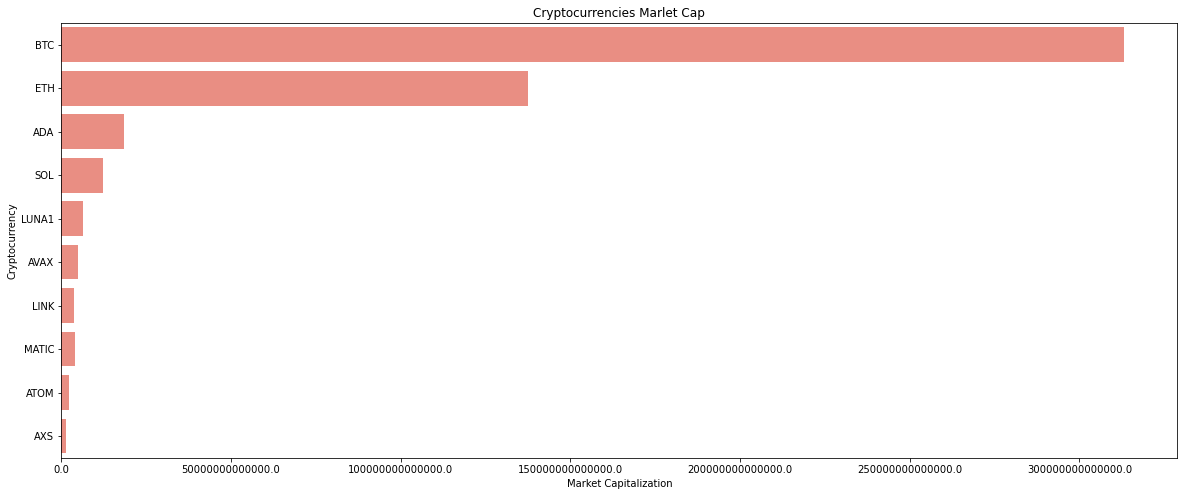

In [18]:
# Plotting cryptos by volume to decide which will be in the indicators
x=10
name = all_data['Asset_ID'].unique()
currency  = []
volume = []
x_currencies = name[:x]
for i, cn in enumerate(x_currencies):
    filtered = all_data[(all_data['Asset_ID']==str(cn))]
    currency.append(str(cn))
    volume.append(filtered['Market Cap'].sum())
        
f, ax = plt.subplots(figsize=(20, 8)) 
g = sns.barplot( y = currency, x = volume, color='salmon')
plt.title("Cryptocurrencies Marlet Cap")
plt.xlabel('Market Capitalization')
plt.ylabel('Cryptocurrency')
ax.set_xticklabels(ax.get_xticks())
fig=plt.gcf()
plt.show()

Bitcoin(BTC) is the top cryptocurrency according to market cap and volume. 
Market cap and volume of other cryptocurrencies are less than 50% of market cap of BTC.

<hr>
<a class="anchor" id="tendency">
    
# 4.2. Tendency
    
</a>

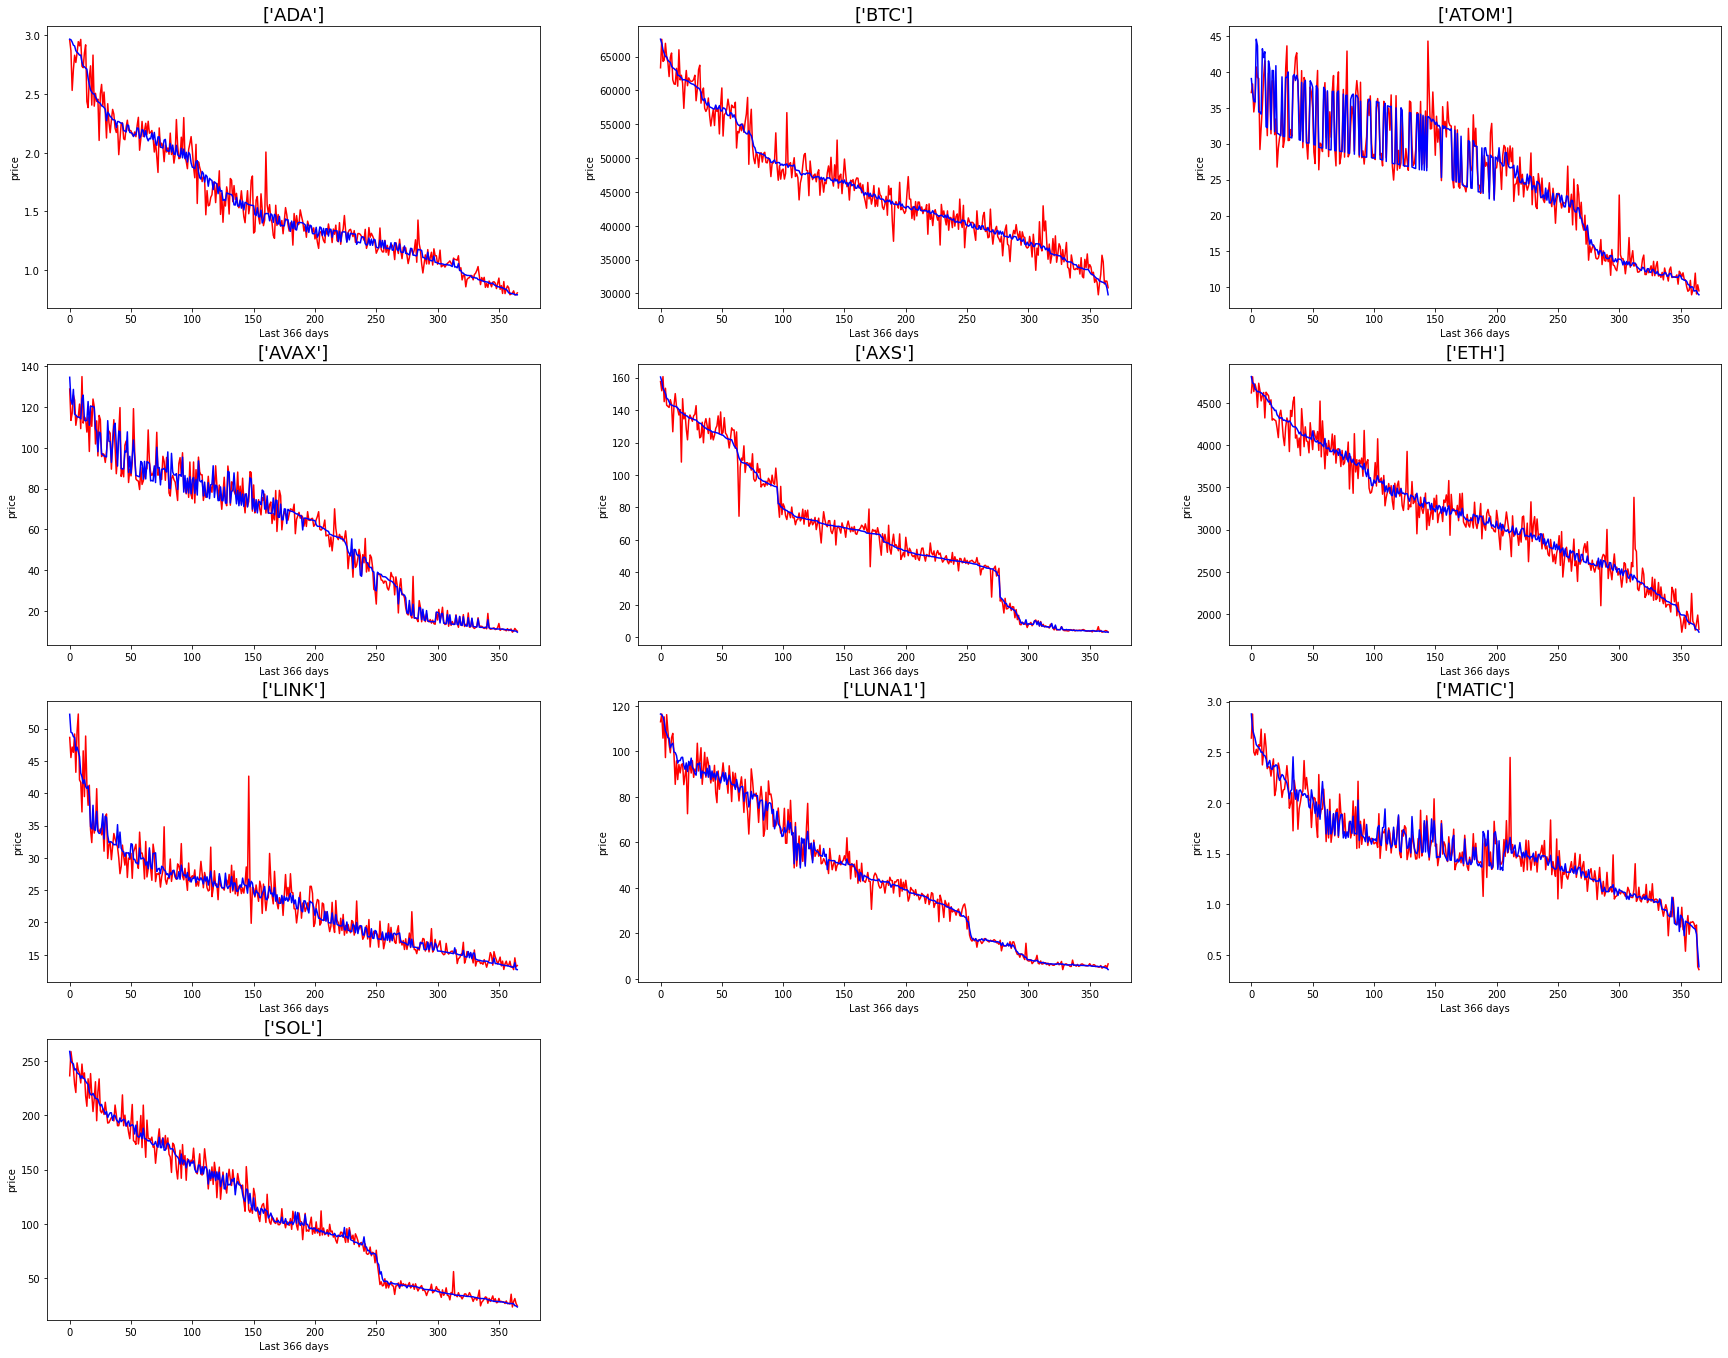

In [19]:
fig = plt.figure(figsize=(30,30))
x=1
for i in all__data.Asset_ID.unique():
    money = all_data[all_data.Asset_ID==i].reset_index(drop=True) 
    fig.add_subplot(5, 3, x)
    plt.title(all__data[all__data.Asset_ID==i].Asset_ID.unique(),fontsize=18)
    plt.plot(money.index,money.open,color="red")
    plt.xlabel('Last 366 days')
    plt.ylabel('price')
    plt.plot(money.index,money.close,color="blue")
    x +=1

Tendency: 

No conclusions given the prices scale, we have to make them at the same scale

<hr>
<a class="anchor" id="heatmap_coin">
    
# 4.3. HeatMap for each Coin
    
</a>


In [20]:
filtered_df = all_data.copy()

In [21]:
## creating a new dataframe with the close values for each coin
check = pd.DataFrame()
for i in filtered_df.Asset_ID.unique():
    check[i] = filtered_df[filtered_df.Asset_ID==i]['close'].reset_index(drop=True)

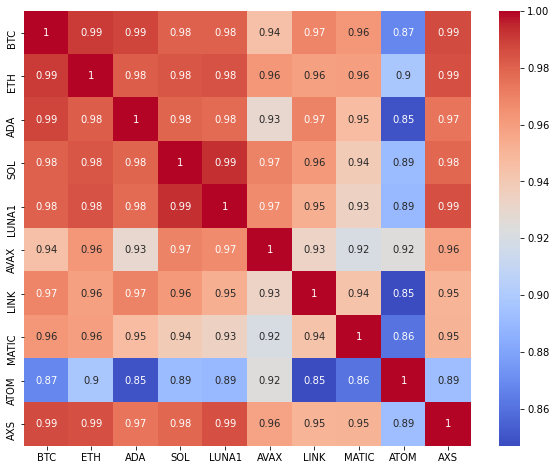

In [22]:
#heatmap for coins
plt.figure(figsize=(10,8))
sns.heatmap(check.dropna().corr(), annot=True, cmap='coolwarm')
plt.show()

<hr>
<a class="anchor" id="heatmap_variables">
    
# 4.4. HeatMap for Bitcoin Variables
    
</a>


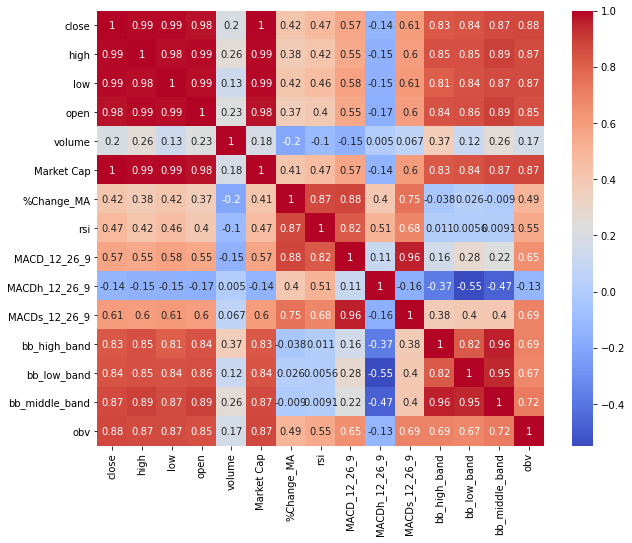

In [23]:
#heatmap for features of BTC
plt.figure(figsize=(10,8))
sns.heatmap(BTC_ind.corr(), annot=True, cmap='coolwarm')
plt.show()

Correlation between OPEN-CLOSE? High correlation

Correlatio between HIGH-LOW? High correlation

<hr>
<a class="anchor" id="per_change">
    
# 4.5. % Change Visualization
    
</a>

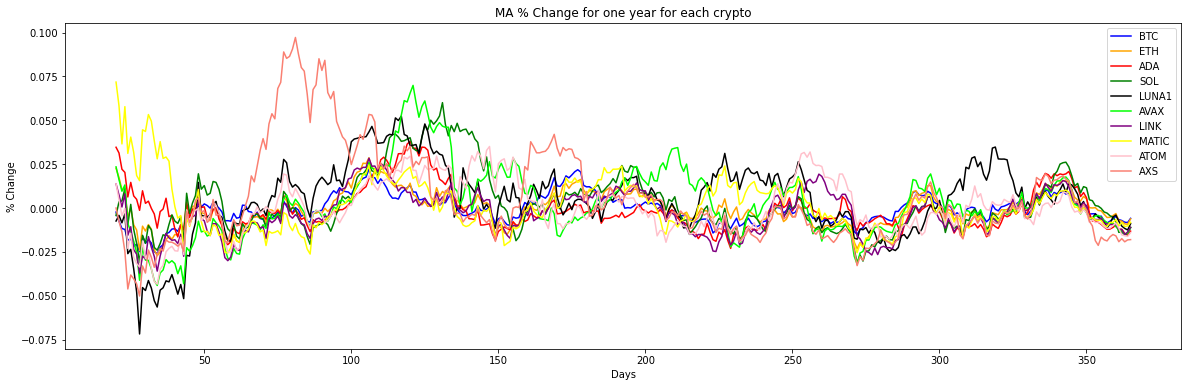

In [24]:
plt.figure(figsize=(20,6))
plt.plot(BTC['%Change_MA'], c='blue');
plt.plot(ETH['%Change_MA'], c='orange');
plt.plot(ADA['%Change_MA'], c='red');
plt.plot(SOL['%Change_MA'], c='green');
plt.plot(LUNA1['%Change_MA'], c='black');
plt.plot(AVAX['%Change_MA'], c='lime');
plt.plot(LINK['%Change_MA'], c='purple');
plt.plot(MATIC['%Change_MA'], c='yellow');
plt.plot(ATOM['%Change_MA'], c='pink');
plt.plot(AXS['%Change_MA'], c='salmon');

plt.title('MA % Change for one year for each crypto')
plt.legend(["BTC" , "ETH", "ADA", "SOL", "LUNA1", "AVAX", "LINK", "MATIC", "ATOM", "AXS" ])
plt.xlabel('Days')
plt.ylabel('% Change')
plt.show()

We can check that they correlate in recent times.But what about stationarity?

<hr>
<a class="anchor" id="stationarity_btc">
    
# 4.6. Stationarity for BTC
    
</a>


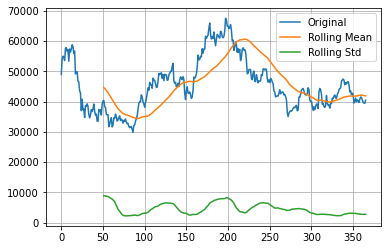

T Statistic            -1.895919
P-Value                 0.333983
#Lags Used              0.000000
#Observations Used    365.000000
Critical value 1%      -3.448394
Critical value 5%      -2.869491
Critical value 10%     -2.571006
dtype: float64


In [25]:
#Stationary Check

def Staionarity_Check(ts):
    plt.plot(ts, label='Original')
    plt.plot(ts.rolling(window=52, center=False).mean(), label='Rolling Mean')
    plt.plot(ts.rolling(window=52, center=False).std(), label='Rolling Std')
    plt.grid()
    plt.legend()
    plt.show()
    
    adf = adfuller(ts, autolag='AIC')
    padf = pd.Series(adf[:4], index=['T Statistic','P-Value','#Lags Used','#Observations Used'])
    for k,v in adf[4].items():
        padf['Critical value {}'.format(k)]=v
    print(padf)
    
Staionarity_Check(BTC['close'])

We can conclude that since the p-value of Bitcoin is  less than .05 (0.044921), we reject the null hypothesis.
Not surprising considering the regular price doesn't keep increasing over the 500 days.

In other words, it doesn't have a time-dependent structure and it does have constant variance over time.

<hr>
<a class="anchor" id="indicators_btc">
    
# 4.7. Indicators analysis for bitcoin
    
</a>


In [26]:
BTC_ind.reset_index(inplace=True)

### Bollinger Band  (volatility)

In [27]:
# Create the bollinger band Plot
fig = go.Figure(data=[
    go.Candlestick(
        x=BTC_ind['Date'],
        open=BTC_ind['open'],
        high=BTC_ind['high'],
        low=BTC_ind['low'],
        close=BTC_ind['close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        showlegend=False,
    ),
])
# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=15,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)

fig.update_layout(layout)

# Add the high band
fig.add_trace(
    go.Scatter(
        x=BTC_ind['Date'],
        y=BTC_ind['bb_high_band'],
        line=dict(color='turquoise', width=2),
        name='bb_high_band'
    )
)

fig.update_layout(layout)

# Add the midle band
fig.add_trace(
    go.Scatter(
        x=BTC_ind['Date'],
        y=BTC_ind['bb_middle_band'],
        line=dict(color='turquoise', width=2,  dash='dot'),
        name='bb_high_band'
    )
)


fig.update_layout(layout)

# Add the low band
fig.add_trace(
    go.Scatter(
        x=BTC_ind['Date'],
        y=BTC_ind['bb_low_band'],
        line=dict(color='turquoise', width=2),
        name='bb_high_band'
    )
)

fig.update_layout(layout, autosize=False,
    width=1010,
    height=500,
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Bands",
    title='Candlestick and Bollinger Band visualization')

# See things again
fig.show()

### RSI, OBV AND MACD

In [28]:
fig = make_subplots(rows=4, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

#candlestick
fig.add_trace(go.Candlestick(
            x=BTC_ind["Date"],
            open=BTC_ind["open"],
            high=BTC_ind["high"],
            low=BTC_ind["low"],
            close=BTC_ind["close"],
            name="OHLC",
        ),
              row=1, col=1)

# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=15,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)


fig.update_layout(layout)

#rsi
fig.append_trace(go.Scatter(
            x=BTC_ind["Date"], y=BTC_ind["rsi"], mode="markers+lines", name="RSI", yaxis="y2",
            line=dict(color='salmon', width = 1)
        ),
      
              row=2, col=1)
fig.add_hrect(y0=30, y1=70, line_width=0, fillcolor="yellow", opacity=0.2)

fig.update_layout(layout)

# obv
fig.append_trace(go.Scatter(
            x=BTC_ind["Date"], y=BTC_ind["obv"], mode="markers+lines", name="obv", yaxis="y3",
            line=dict(color='blue', width = 0.8)
        ),
      
              row=3, col=1)

fig.update_layout(layout)

colors = np.where(BTC_ind['MACDh_12_26_9'] < 0, 'red', 'green')

# macd histogram
fig.append_trace(
    go.Bar(
        x=BTC_ind['Date'],
        y=BTC_ind['MACDh_12_26_9'],
        name='MACDh_12_26_9',
        marker_color=colors
    ), row=4, col=1
)

fig.update_layout(layout)

# macd line
fig.append_trace(
    go.Scatter(
        x=BTC_ind['Date'],
        y=BTC_ind['MACD_12_26_9'],
        line=dict(color='blue', width=2),
        # showlegend=False,
        legendgroup='1',
        name='MACD_12_26_9'
    ), row=4, col=1
)

# macd signal
fig.append_trace(
    go.Scatter(
        x=BTC_ind['Date'],
        y=BTC_ind['MACDs_12_26_9'],
        line=dict(color='gold', width=2),
        # showlegend=False,
        legendgroup='1',
        name='MACDs_12_26_9'
    ), row=4, col=1
)



fig.update_layout(height=1000, width=1000,
                  title_text="Candlestick and indicators visualization ( RSI, OBV AND MACD)", xaxis_rangeslider_visible=False,
                 yaxis_title="Price",
                 )
fig.show()

<hr>
<a class="anchor" id="models">
    
# 5. Models (trial Bitcoin only)
    
</a>

In [29]:
BTC.set_index('Date', inplace=True)
ETH.set_index('Date', inplace=True)
ADA.set_index('Date', inplace=True)
SOL.set_index('Date', inplace=True)
LUNA1.set_index('Date', inplace=True)
AVAX.set_index('Date', inplace=True)
LINK.set_index('Date', inplace=True)
MATIC.set_index('Date', inplace=True)
ATOM.set_index('Date', inplace=True)
AXS.set_index('Date', inplace=True)

In [30]:
# creating new dataframe of Bitcoin data containing only date and closing price
BTC_close = BTC['close'].reset_index()

In [31]:
# normalizing close price value

del BTC_close['Date']
scaler = MinMaxScaler(feature_range=(0,1))
BTC_close = scaler.fit_transform(np.array(BTC_close).reshape(-1,1))
print(BTC_close.shape)

(366, 1)


In [ ]:
# separate data for train and test

training_size=int(len(BTC_close)*0.70)
test_size=len(BTC_close)-training_size
train_data,test_data=BTC_close[0:training_size,:],BTC_close[training_size:len(BTC_close),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (256, 1)
test_data:  (110, 1)


In [ ]:
# prepare train data for time series analysis

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

<hr>
<a class="anchor" id="xgboost">
    
### 5.1. XGBoost
    
</a>

In [ ]:
# predicting using the last 18 days
time_step = 18
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (237, 18)
y_train:  (237,)
X_test:  (91, 18)
y_test (91,)


In [ ]:
# building XGBoost Regressor model

xgbr = XGBRegressor(random_state=93)
xgbr.fit(X_train, y_train)

[13:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=93)

In [ ]:
predictions = xgbr.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.03253065470221606
Root Mean squared Error - RMSE : 0.04339053376799644


In [ ]:
# Define the grid to explore
xgbr_params = {
    'booster':['gbtree', 'gblinear', 'dart'],
    'n_estimators':[60, 70, 80, 100, 120],
    'max_depth':[2, 4, 6, 8],
    'predictor':['auto', 'cpu_predictor'],
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5]}

xgbr = XGBRegressor(random_state=93)
gscv = GridSearchCV(estimator = xgbr, scoring = 'neg_mean_squared_error', param_grid = xgbr_params, verbose = -1, n_jobs = 4)

In [ ]:
gscv.fit(X_train, y_train)

gscv.best_params_

[13:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1000 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 396, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", li

{'booster': 'gbtree',
 'learning_rate': 0.4,
 'max_depth': 2,
 'n_estimators': 80,
 'predictor': 'cpu_predictor'}

In [ ]:
# building XGBoost Regressor model

xgbr = XGBRegressor(booster = 'gbtree', learning_rate = 0.4, max_depth = 2, n_estimators = 80, predictor = 'cpu_predictor')
xgbr.fit(X_train, y_train)

[13:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=2, n_estimators=80,
             predictor='cpu_predictor')

In [ ]:
predictions_xgbr = xgbr.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions_xgbr)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions_xgbr))))

Mean Absolute Error - MAE : 0.0359859662462894
Root Mean squared Error - RMSE : 0.049137772637570576


In [ ]:
train_predict=xgbr.predict(X_train)
test_predict=xgbr.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (237, 1)
Test data prediction: (91, 1)


In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  507.44183681512493
Train data MSE:  257497.2177503079
Train data MAE:  375.73482825685653
-------------------------------------------------------------------------------------
Test data RMSE:  1855.4166665442517
Test data MSE:  3442571.0064901826
Test data MAE:  1358.8113839285713


<hr>
<a class="anchor" id="lstm">
    
### 5.2. LSTM
    
</a>

In [ ]:
# predicting using the last 30 days
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (225, 30)
y_train:  (225,)
X_test:  (79, 30)
y_test (79,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (225, 30, 1)
X_test:  (79, 30, 1)


In [ ]:
tf.random.set_seed(93)

lstm = Sequential()

lstm.add(LSTM(40,input_shape=(None,1),activation="relu"))

lstm.add(Dense(1))

lstm.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
history = lstm.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=600, batch_size=32, verbose=1)

Epoch 1/600
8/8 [==============================] - 4s 124ms/step - loss: 0.2856 - val_loss: 0.0818
Epoch 2/600
8/8 [==============================] - 0s 45ms/step - loss: 0.2066 - val_loss: 0.0448
Epoch 3/600
8/8 [==============================] - 0s 35ms/step - loss: 0.1239 - val_loss: 0.0114
Epoch 4/600
8/8 [==============================] - 0s 34ms/step - loss: 0.0420 - val_loss: 0.0160
Epoch 5/600
8/8 [==============================] - 0s 39ms/step - loss: 0.0334 - val_loss: 0.0147
Epoch 6/600
8/8 [==============================] - 0s 29ms/step - loss: 0.0176 - val_loss: 0.0051
Epoch 7/600
8/8 [==============================] - 0s 29ms/step - loss: 0.0197 - val_loss: 0.0049
Epoch 8/600
8/8 [==============================] - 0s 28ms/step - loss: 0.0157 - val_loss: 0.0110
Epoch 9/600
8/8 [==============================] - 0s 25ms/step - loss: 0.0186 - val_loss: 0.0129
Epoch 10/600
8/8 [==============================] - 0s 26ms/step - loss: 0.0138 - val_loss: 0.0052
Epoch 11/600
8/8 [

In [ ]:
predictions_lstm = lstm.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions_lstm)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions_lstm))))

Mean Absolute Error - MAE : 0.026655157584986947
Root Mean squared Error - RMSE : 0.03621377760217322


In [ ]:
 ### Lets Do the prediction and check performance metrics
train_predict = lstm.predict(X_train)
test_predict = lstm.predict(X_test)
train_predict.shape, test_predict.shape

((225, 1), (79, 1))

In [ ]:
# transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1641.490345367077
Train data MSE:  2694490.5539333257
Train data MAE:  1256.1832378472222
-------------------------------------------------------------------------------------
Test data RMSE:  1367.4133861228104
Test data MSE:  1869819.3685478503
Test data MAE:  1006.4849189082279


<hr>
<a class="anchor" id="bilstm">
    
### 5.3. BiLSTM
    
</a>

In [ ]:
# predicting using the last 18 days
time_step = 18
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (237, 18)
y_train:  (237,)
X_test:  (91, 18)
y_test (91,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for BiLSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (237, 18, 1)
X_test:  (91, 18, 1)


In [ ]:
tf.random.set_seed(93)

bilstm = Sequential()

# first layer of BiLSTM
bilstm.add(Bidirectional(LSTM(40, return_sequences=True), 
                         input_shape=(X_train.shape[1], X_train.shape[2])))

# Second layer of BiLSTM
bilstm.add(Bidirectional(LSTM(40)))
bilstm.add(Dense(1))
#Compile model
bilstm.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = bilstm.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=500, batch_size=32, verbose=1)

Epoch 1/500
8/8 [==============================] - 16s 381ms/step - loss: 0.0692 - val_loss: 0.0324
Epoch 2/500
8/8 [==============================] - 0s 35ms/step - loss: 0.0252 - val_loss: 0.0055
Epoch 3/500
8/8 [==============================] - 0s 36ms/step - loss: 0.0192 - val_loss: 0.0052
Epoch 4/500
8/8 [==============================] - 0s 35ms/step - loss: 0.0150 - val_loss: 0.0080
Epoch 5/500
8/8 [==============================] - 0s 36ms/step - loss: 0.0126 - val_loss: 0.0047
Epoch 6/500
8/8 [==============================] - 0s 35ms/step - loss: 0.0117 - val_loss: 0.0051
Epoch 7/500
8/8 [==============================] - 0s 35ms/step - loss: 0.0108 - val_loss: 0.0044
Epoch 8/500
8/8 [==============================] - 0s 34ms/step - loss: 0.0095 - val_loss: 0.0041
Epoch 9/500
8/8 [==============================] - 0s 38ms/step - loss: 0.0087 - val_loss: 0.0040
Epoch 10/500
8/8 [==============================] - 0s 36ms/step - loss: 0.0079 - val_loss: 0.0036
Epoch 11/500
8/8 

In [ ]:
predictions_bilstm = bilstm.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions_bilstm)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions_bilstm))))

Mean Absolute Error - MAE : 0.028812972251906654
Root Mean squared Error - RMSE : 0.03945955801629278


In [ ]:
 ### Lets Do the prediction and check performance metrics
train_predict = bilstm.predict(X_train)
test_predict = bilstm.predict(X_test)
train_predict.shape, test_predict.shape

((237, 1), (91, 1))

In [ ]:
# transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1663.4815610078704
Train data MSE:  2767170.903813181
Train data MAE:  1281.596675566983
-------------------------------------------------------------------------------------
Test data RMSE:  1489.9721710389272
Test data MSE:  2220017.070470454
Test data MAE:  1087.9626545329675


<hr>
<a class="anchor" id="gru">
    
### 5.4. GRU
    
</a>

In [ ]:
# predicting using the last 18 days
time_step = 18
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)

print("y_test", y_test.shape)

X_train:  (237, 18)
y_train:  (237,)
X_test:  (91, 18)
y_test (91,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (237, 18, 1)
X_test:  (91, 18, 1)


In [ ]:
tf.random.set_seed(93)

gru = Sequential()

# first layer of LSTM
gru.add(GRU(20, return_sequences = True, 
             input_shape = [X_train.shape[1], X_train.shape[2]]))
# second layer of LSTM
gru.add(GRU(20))                 
gru.add(Dense(1)) 

#Compile model
gru.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = gru.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=600, batch_size=32, verbose=1)

Epoch 1/600
8/8 [==============================] - 5s 133ms/step - loss: 0.0525 - val_loss: 0.0044
Epoch 2/600
8/8 [==============================] - 0s 23ms/step - loss: 0.0137 - val_loss: 0.0179
Epoch 3/600
8/8 [==============================] - 0s 21ms/step - loss: 0.0122 - val_loss: 0.0039
Epoch 4/600
8/8 [==============================] - 0s 20ms/step - loss: 0.0081 - val_loss: 0.0026
Epoch 5/600
8/8 [==============================] - 0s 21ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 6/600
8/8 [==============================] - 0s 21ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 7/600
8/8 [==============================] - 0s 21ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 8/600
8/8 [==============================] - 0s 23ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 9/600
8/8 [==============================] - 0s 21ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 10/600
8/8 [==============================] - 0s 21ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 11/600
8/8 [

In [ ]:
predictions_gru = gru.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions_gru)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions_gru))))

Mean Absolute Error - MAE : 0.025013211641611802
Root Mean squared Error - RMSE : 0.03540337714800484


In [ ]:
 ### Lets Do the prediction and check performance metrics
train_predict = gru.predict(X_train)
test_predict = gru.predict(X_test)
train_predict.shape, test_predict.shape

((237, 1), (91, 1))

In [ ]:
# transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain, train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain, train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest, test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest, test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest, test_predict))

Train data RMSE:  1713.1116803606226
Train data MSE:  2934751.629387996
Train data MAE:  1311.5231243407172
-------------------------------------------------------------------------------------
Test data RMSE:  1336.8133067844658
Test data MSE:  1787069.817196018
Test data MAE:  944.4859203296703


<hr>
<a class="anchor" id="svm">
    
### 5.5. Support Vector Machine
    
</a>

In [ ]:
# predicting using the last 18 days
time_step = 18
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (237, 18)
y_train:  (237,)
X_test:  (91, 18)
y_test (91,)


In [ ]:
# building SVM Regressor model

svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [ ]:
predictions_svr = svr.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions_svr)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions_svr))))

Mean Absolute Error - MAE : 0.05035179800867746
Root Mean squared Error - RMSE : 0.06327298704383923


In [ ]:
# Define the grid to explore
svr_params = {
    'kernel':['linear', 'rbf', 'sigmoid'],
    'gamma':['scale', 'auto'],
    'C':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'epsilon':[0.01, 0.05, 0.1],
    'tol':[1e-06, 1e-05, 1e-04, 1e-03]
}

svr = SVR()
gscv = GridSearchCV(estimator = svr, scoring = 'neg_mean_squared_error', param_grid = svr_params, verbose = -1, n_jobs = 4)

In [ ]:
gscv.fit(X_train, y_train)

gscv.best_params_

{'C': 0.6, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'tol': 1e-06}

In [ ]:
predictions_svr = gscv.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions_svr)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions_svr))))

Mean Absolute Error - MAE : 0.02694999587745099
Root Mean squared Error - RMSE : 0.037141723503874305


In [ ]:
train_predict=gscv.predict(X_train)
test_predict=gscv.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (237, 1)
Test data prediction: (91, 1)


In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1712.1422004770975
Train data MSE:  2931430.9146545576
Train data MAE:  1285.2661729443132
-------------------------------------------------------------------------------------
Test data RMSE:  1402.4521832202547
Test data MSE:  1966872.1262192589
Test data MAE:  1017.6178429675036


<hr>
<a class="anchor" id="modelgen">
    
# 6. Models (generalization)
    
</a>

In [ ]:
# testing for GRU model since it gave the lower error for BTC

def gru(coin_df, coin_name):
  close = coin_df['close'].reset_index()

  del close['Date']
  scaler = MinMaxScaler(feature_range=(0,1))
  close = scaler.fit_transform(np.array(close).reshape(-1,1))

  training_size=int(len(close)*0.70)
  test_size=len(close)-training_size
  train_data,test_data=close[0:training_size,:],close[training_size:len(close),:1]

  time_step = 18
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)

  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

  tf.random.set_seed(93)

  gru = Sequential()

  # first layer of LSTM
  gru.add(GRU(20, return_sequences = True, 
              input_shape = [X_train.shape[1], X_train.shape[2]]))
  # second layer of LSTM
  gru.add(GRU(20))                 
  gru.add(Dense(1)) 

  #Compile model
  gru.compile(loss='mean_squared_error', optimizer='adam')

  history = gru.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=600, batch_size=32, verbose=0)

  predictions_gru = gru.predict(X_test)

  print(coin_name + ":")
  print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions_gru)))
  print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions_gru))) + "\n")


In [ ]:
gru(ADA, 'ADA')
gru(BTC, 'BTC')
gru(ATOM, 'ATOM')
gru(AVAX, 'AVAX')
gru(AXS, 'AXS')
gru(ETH, 'ETH')
gru(LINK, 'LINK')
gru(LUNA1, 'LUNA1')
gru(MATIC, 'MATIC')
gru(SOL, 'SOL')

ADA:
Mean Absolute Error - MAE : 0.01875248115622742
Root Mean squared Error - RMSE : 0.02380707206726721

BTC:
Mean Absolute Error - MAE : 0.025013211641611802
Root Mean squared Error - RMSE : 0.03540337714800484

ATOM:
Mean Absolute Error - MAE : 0.03699014429296235
Root Mean squared Error - RMSE : 0.04983981604943875

AVAX:
Mean Absolute Error - MAE : 0.02610978971663818
Root Mean squared Error - RMSE : 0.03184677536823626

AXS:
Mean Absolute Error - MAE : 0.01986840345056102
Root Mean squared Error - RMSE : 0.02447061660555961

ETH:
Mean Absolute Error - MAE : 0.02596792794665981
Root Mean squared Error - RMSE : 0.03419647977796318

LINK:
Mean Absolute Error - MAE : 0.018402668367385133
Root Mean squared Error - RMSE : 0.02255985975076902

LUNA1:
Mean Absolute Error - MAE : 0.03556997636768882
Root Mean squared Error - RMSE : 0.04755999129371436

MATIC:
Mean Absolute Error - MAE : 0.024127767925729945
Root Mean squared Error - RMSE : 0.032803167481942966

SOL:
Mean Absolute Error -

In [ ]:
# testing for SVR model since it also gave lower error for BTC

def svr(coin_df, coin_name):
  close = coin_df['close'].reset_index()

  del close['Date']
  scaler = MinMaxScaler(feature_range=(0,1))
  close = scaler.fit_transform(np.array(close).reshape(-1,1))

  training_size=int(len(close)*0.70)
  test_size=len(close)-training_size
  train_data,test_data=close[0:training_size,:],close[training_size:len(close),:1]

  time_step = 18
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)

  svr_params = {
      'kernel':['linear', 'rbf', 'sigmoid'],
      'gamma':['scale', 'auto'],
      'C':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
      'epsilon':[0.01, 0.05, 0.1],
      'tol':[1e-06, 1e-05, 1e-04, 1e-03]
      }

  svr = SVR()
  gscv = GridSearchCV(estimator = svr, scoring = 'neg_mean_squared_error', param_grid = svr_params, verbose = -1, n_jobs = 4)
  gscv.fit(X_train, y_train)

  predictions_svr = gscv.predict(X_test)

  print(coin_name + ":")
  print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions_svr)))
  print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions_svr))) + "\n")

In [ ]:
svr(ADA, 'ADA')
svr(BTC, 'BTC')
svr(ATOM, 'ATOM')
svr(AVAX, 'AVAX')
svr(AXS, 'AXS')
svr(ETH, 'ETH')
svr(LINK, 'LINK')
svr(LUNA1, 'LUNA1')
svr(MATIC, 'MATIC')
svr(SOL, 'SOL')

ADA:
Mean Absolute Error - MAE : 0.016741751354872197
Root Mean squared Error - RMSE : 0.02128910488778769

BTC:
Mean Absolute Error - MAE : 0.02694999587745099
Root Mean squared Error - RMSE : 0.037141723503874305

ATOM:
Mean Absolute Error - MAE : 0.032398727362630435
Root Mean squared Error - RMSE : 0.04323175280832359

AVAX:
Mean Absolute Error - MAE : 0.02719472775615881
Root Mean squared Error - RMSE : 0.033720163532848436

AXS:
Mean Absolute Error - MAE : 0.01574475722072529
Root Mean squared Error - RMSE : 0.021287436263019852

ETH:
Mean Absolute Error - MAE : 0.02691203622659793
Root Mean squared Error - RMSE : 0.035224615873927397

LINK:
Mean Absolute Error - MAE : 0.01776867659859517
Root Mean squared Error - RMSE : 0.022208982964102255

LUNA1:
Mean Absolute Error - MAE : 0.03849033977824164
Root Mean squared Error - RMSE : 0.049507318581585635

MATIC:
Mean Absolute Error - MAE : 0.022354126170310008
Root Mean squared Error - RMSE : 0.030391523241715235

SOL:
Mean Absolute E

In [ ]:
# some coins had lower errors with GRU model and others with SVR model
# so the GRU will be used to predict the prices of BTC, AVAX, ETH, LUNA1
# and SVR for the others

# this function receives the coin dataframe and name
# will return the errors (MAE and RMSE), a plot with the comparison between the real values and the
# predicted ones and a prediction for 27/04/2022 (two days after the last day of the dataframe)

def build_model(coin_df, coin_name):

  # creating new dataframe of the coin data containing only date and closing price
  close = coin_df['close'].reset_index()

  close.index = np.arange(1, len(close) + 1)
  close_stock = close.copy()

  # normalizing close price value
  del close['Date']
  scaler = MinMaxScaler(feature_range=(0,1))
  close = scaler.fit_transform(np.array(close).reshape(-1,1))

  # separate data for train and test
  training_size=int(len(close)*0.70)
  test_size=len(close)-training_size
  train_data,test_data=close[0:training_size,:],close[training_size:len(close),:1]

  # we will be predicting the close price using the close prices of the 18 days before
  time_step = 18
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)

  # build GRU model if the coin is BTC, AVAX, ETH or LUNA1
  if coin_name in ['BTC', 'AVAX', 'ETH', 'LUNA1']:
    
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    tf.random.set_seed(93)

    gru = Sequential()

    # first layer of GRU
    gru.add(GRU(20, return_sequences = True, 
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    # second layer of GRU
    gru.add(GRU(20))                 
    gru.add(Dense(1)) 

    #Compile model
    gru.compile(loss='mean_squared_error', optimizer='adam')

    history = gru.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=600, batch_size=32, verbose=0)

    train_predict = gru.predict(X_train)
    test_predict = gru.predict(X_test)

    print(coin_name + ":")
    print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, test_predict)))
    print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, test_predict))))

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)

    # transform back to original form
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
    original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 


    # shift train predictions for plotting
    look_back=time_step
    train_predict_plot = np.empty_like(close)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict


    # shift test predictions for plotting
    test_predict_plot = np.empty_like(close)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict)+(look_back*2)+1:len(close)-1, :] = test_predict


    names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

    plot_df = pd.DataFrame({'Date': close_stock['Date'],
                            'original_close': close_stock['close'],
                            'train_predicted_close': train_predict_plot.reshape(1,-1)[0].tolist(),
                            'test_predicted_close': test_predict_plot.reshape(1,-1)[0].tolist()})

    # plotting the real close prices and the predicted ones
    fig = px.line(plot_df, x = plot_df['Date'], 
                  y = [plot_df['original_close'], plot_df['train_predicted_close'], plot_df['test_predicted_close']],
                  labels={'value':'Close price','Date': 'Date'})

    fig.update_layout(title_text=f'{coin_name}: Comparision between original close price vs predicted close price',
                      plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
    
    fig.for_each_trace(lambda t:  t.update(name = next(names)))

    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()


    # prediction next 2 days
    x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps=time_step
    i=0
    pred_days = 2
    
    while(i<pred_days):
      
      if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = gru.predict(x_input)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
      else:
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = gru.predict(x_input)
        
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
    
    
    close=close.tolist()
    close.extend((np.array(lst_output).reshape(-1,1)).tolist())
    close=scaler.inverse_transform(close).reshape(1,-1).tolist()[0]

    print("Close price (USD) prediction for 27th April 2022: " + str(close[-1]) + "\n")


  # build SVR model for the rest of the coins
  else:
    svr_params = {
        'kernel':['linear', 'rbf', 'sigmoid'],
        'gamma':['scale', 'auto'],
        'C':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'epsilon':[0.01, 0.05, 0.1],
        'tol':[1e-06, 1e-05, 1e-04, 1e-03]
        }

    svr = SVR()

    # find the best hyper parameters for train set
    gscv = GridSearchCV(estimator = svr, scoring = 'neg_mean_squared_error', param_grid = svr_params, verbose = -1, n_jobs = 4)
    gscv.fit(X_train, y_train)

    train_predict = gscv.predict(X_train)
    test_predict = gscv.predict(X_test)

    print(coin_name + ":")
    print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, test_predict)))
    print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, test_predict))))

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)

    # transform back to original form

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
    original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 


    # shift train predictions for plotting

    look_back=time_step
    train_predict_plot = np.empty_like(close)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict


    # shift test predictions for plotting
    test_predict_plot = np.empty_like(close)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict)+(look_back*2)+1:len(close)-1, :] = test_predict


    names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

    plot_df = pd.DataFrame({'Date': close_stock['Date'],
                            'original_close': close_stock['close'],
                            'train_predicted_close': train_predict_plot.reshape(1,-1)[0].tolist(),
                            'test_predicted_close': test_predict_plot.reshape(1,-1)[0].tolist()})

    # plotting the real close prices and the predicted ones
    fig = px.line(plot_df, x = plot_df['Date'], 
                  y = [plot_df['original_close'], plot_df['train_predicted_close'], plot_df['test_predicted_close']],
                  labels={'value':'Close price','Date': 'Date'})

    fig.update_layout(title_text=f'{coin_name}: Comparision between original close price vs predicted close price',
                      plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
    
    fig.for_each_trace(lambda t:  t.update(name = next(names)))

    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

    # prediction next 2 days
    x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()


    lst_output=[]
    n_steps=time_step
    i=0
    pred_days = 2
    
    while(i<pred_days):
      
      if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        
        yhat = gscv.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
      else:
        yhat = gscv.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1

    close=close.tolist()
    close.extend((np.array(lst_output).reshape(-1,1)).tolist())
    close=scaler.inverse_transform(close).reshape(1,-1).tolist()[0]

    print("Close price (USD) prediction for 27th April 2022: " + str(close[-1]) + "\n")

In [ ]:
# building model for ADA
build_model(ADA, 'ADA')

ADA:
Mean Absolute Error - MAE : 0.016741751354872197
Root Mean squared Error - RMSE : 0.02128910488778769


Close price (USD) prediction for 27th April 2022: 0.94643722104014



In [ ]:
# building model for BTC
build_model(BTC, 'BTC')

BTC:
Mean Absolute Error - MAE : 0.025013211969109852
Root Mean squared Error - RMSE : 0.0354033782095791


Close price (USD) prediction for 27th April 2022: 40438.851978221326



In [ ]:
# building model for ATOM
build_model(ATOM, 'ATOM')

ATOM:
Mean Absolute Error - MAE : 0.032398727362630435
Root Mean squared Error - RMSE : 0.04323175280832359


Close price (USD) prediction for 27th April 2022: 23.0701560806588



In [ ]:
# building model for AVAX
build_model(AVAX, 'AVAX')

AVAX:
Mean Absolute Error - MAE : 0.02610980609154059
Root Mean squared Error - RMSE : 0.03184678783802008


Close price (USD) prediction for 27th April 2022: 72.27904229030946



In [ ]:
# building model for AXS
build_model(AXS, 'AXS')

AXS:
Mean Absolute Error - MAE : 0.01574475722072529
Root Mean squared Error - RMSE : 0.021287436263019852


Close price (USD) prediction for 27th April 2022: 44.67548641147526



In [ ]:
# building model for ETH
build_model(ETH, 'ETH')

ETH:
Mean Absolute Error - MAE : 0.025967933350377607
Root Mean squared Error - RMSE : 0.034196482550239785


Close price (USD) prediction for 27th April 2022: 2992.7202472114295



In [ ]:
# building model for LINK
build_model(LINK, 'LINK')

LINK:
Mean Absolute Error - MAE : 0.01776867659859517
Root Mean squared Error - RMSE : 0.022208982964102255


Close price (USD) prediction for 27th April 2022: 14.628605328721962



In [ ]:
# building model for LUNA1
build_model(LUNA1, 'LUNA1')

LUNA1:
Mean Absolute Error - MAE : 0.03556998455514002
Root Mean squared Error - RMSE : 0.04756000189673012


Close price (USD) prediction for 27th April 2022: 94.17683218022307



In [ ]:
# building model for MATIC
build_model(MATIC, 'MATIC')

MATIC:
Mean Absolute Error - MAE : 0.022354126170310008
Root Mean squared Error - RMSE : 0.030391523241715235


Close price (USD) prediction for 27th April 2022: 1.347237155898909



In [ ]:
# building model for SOL
build_model(SOL, 'SOL')

SOL:
Mean Absolute Error - MAE : 0.017164938955794292
Root Mean squared Error - RMSE : 0.021897852496347205


Close price (USD) prediction for 27th April 2022: 102.09671026337988



<hr>
<a class="anchor" id="predict">
    
# 7.  Predicting close price for May 10th 2022
    
</a>

In [ ]:
path2 = 'https://raw.githubusercontent.com/joaopfonseca/business-cases-21-22/main/BC4_crypto_forecasting/data_updated/'

adj_close_upd = pd.read_csv(path2 + 'adj_close.csv')
close_upd = pd.read_csv(path2 + 'close.csv')
high_upd = pd.read_csv(path2 + 'high.csv')
low_upd = pd.read_csv(path2 + 'low.csv')
open_upd = pd.read_csv(path2 + 'open.csv')
volume_upd = pd.read_csv(path2 + 'volume.csv')


In [ ]:
# it makes more sense to have a dataframe for each cryptocurrency with close, high, etc as columns
# instead of working with data how it was originally provided

def create_crypto_df(crypto):
    
    name = [close_upd['Date'], close_upd[crypto], adj_close_upd[crypto], high_upd[crypto], 
            low_upd[crypto], open_upd[crypto], volume_upd[crypto]]

    df = pd.concat(name, axis = 1).set_index('Date').dropna()

    df.columns = ['close', 'adj_close', 'high', 'low', 'open', 'volume']
    
    return df

In [ ]:
# creation of the dataframes for each cryptocurrency

ADA = create_crypto_df('ADA-USD')
BTC = create_crypto_df('BTC-USD')
ATOM = create_crypto_df('ATOM-USD')
AVAX = create_crypto_df('AVAX-USD')
AXS = create_crypto_df('AXS-USD')
ETH = create_crypto_df('ETH-USD')
LINK = create_crypto_df('LINK-USD')
LUNA1 = create_crypto_df('LUNA1-USD')
MATIC = create_crypto_df('MATIC-USD')
SOL = create_crypto_df('SOL-USD')

In [ ]:
# we're only going to use the last 366 in order to don't have bad influence of the older data on our predictions


ADA = ADA.iloc[-366:]
BTC = BTC.iloc[-366:]
ATOM = ATOM.iloc[-366:]
AVAX = AVAX.iloc[-366:]
AXS = AXS.iloc[-366:]
ETH = ETH.iloc[-366:]
LINK = LINK.iloc[-366:]
LUNA1 = LUNA1.iloc[-366:]
MATIC = MATIC.iloc[-366:]
SOL = SOL.iloc[-366:]

In [ ]:
!pip install ta

  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=96f43a30b39757e3f680504b9cca09b350e5471e891be13d04015715c303db33
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta


In [ ]:
import ta

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

BTC['%Change']=log_return(BTC.close)[1:]
ETH['%Change']=log_return(ETH.close)[1:]
ADA['%Change']=log_return(ADA.close)[1:]
LUNA1['%Change']=log_return(LUNA1.close)[1:]
AVAX['%Change']=log_return(AVAX.close)[1:]
LINK['%Change']=log_return(LINK.close)[1:]
MATIC['%Change']=log_return(MATIC.close)[1:]
ATOM['%Change']=log_return(ATOM.close)[1:]
AXS['%Change']=log_return(AXS.close)[1:]
SOL['%Change']=log_return(SOL.close)[1:]

##creating the Moving Average % Change 
BTC["%Change_MA"] = ta.volatility.bollinger_mavg(BTC["%Change"])
ETH["%Change_MA"] = ta.volatility.bollinger_mavg(ETH["%Change"])
ADA["%Change_MA"] = ta.volatility.bollinger_mavg(ADA["%Change"])
LUNA1["%Change_MA"] = ta.volatility.bollinger_mavg(LUNA1["%Change"])
AVAX["%Change_MA"] = ta.volatility.bollinger_mavg(AVAX["%Change"])
LINK["%Change_MA"] = ta.volatility.bollinger_mavg(LINK["%Change"])
MATIC["%Change_MA"] = ta.volatility.bollinger_mavg(MATIC["%Change"])
ATOM["%Change_MA"] = ta.volatility.bollinger_mavg(ATOM["%Change"])
AXS["%Change_MA"] = ta.volatility.bollinger_mavg(AXS["%Change"])
SOL["%Change_MA"] = ta.volatility.bollinger_mavg(SOL["%Change"])

                                                 
#dropping the column %Change for each dataframe
BTC.drop('%Change', axis=1, inplace=True)
ETH.drop('%Change', axis=1, inplace=True)
ADA.drop('%Change', axis=1, inplace=True)
LUNA1.drop('%Change', axis=1, inplace=True)
AVAX.drop('%Change', axis=1, inplace=True)     
LINK.drop('%Change', axis=1, inplace=True)
MATIC.drop('%Change', axis=1, inplace=True)
ATOM.drop('%Change', axis=1, inplace=True)
AXS.drop('%Change', axis=1, inplace=True)
SOL.drop('%Change', axis=1, inplace=True)

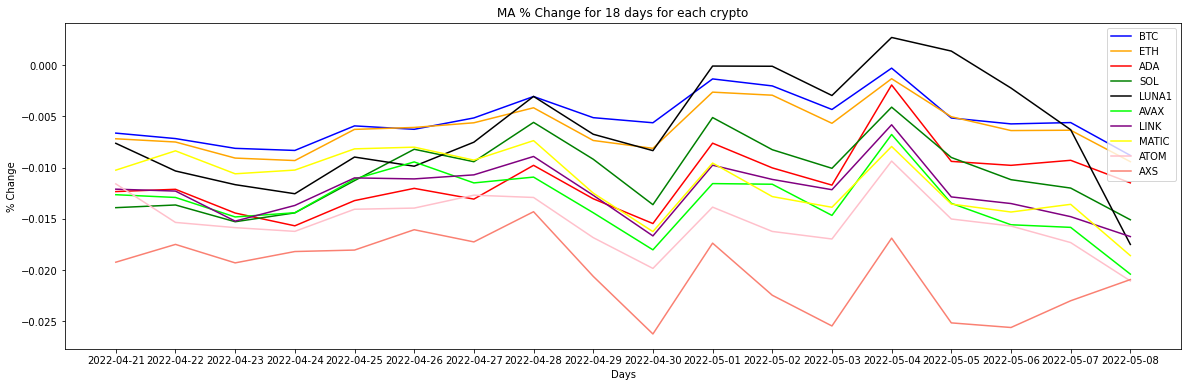

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(BTC[-18:]['%Change_MA'], c='blue');
plt.plot(ETH[-18:]['%Change_MA'], c='orange');
plt.plot(ADA[-18:]['%Change_MA'], c='red');
plt.plot(SOL[-18:]['%Change_MA'], c='green');
plt.plot(LUNA1[-18:]['%Change_MA'], c='black');
plt.plot(AVAX[-18:]['%Change_MA'], c='lime');
plt.plot(LINK[-18:]['%Change_MA'], c='purple');
plt.plot(MATIC[-18:]['%Change_MA'], c='yellow');
plt.plot(ATOM[-18:]['%Change_MA'], c='pink');
plt.plot(AXS[-18:]['%Change_MA'], c='salmon');

plt.title('MA % Change for 18 days for each crypto')
plt.legend(["BTC" , "ETH", "ADA", "SOL", "LUNA1", "AVAX", "LINK", "MATIC", "ATOM", "AXS" ])
plt.xlabel('Days')
plt.ylabel('% Change')
plt.show()

In [ ]:
# some coins had lower errors with GRU model and others with SVR model
# so the GRU will be used to predict the prices of BTC, AVAX, ETH, LUNA1
# and SVR for the others

# this function receives the coin dataframe and name
# will return the errors (MAE and RMSE) and a prediction for 10/05/2022 
# (two days after the last day of the dataframe)

def predict_close(coin_df, coin_name):

  # creating new dataframe of the coin data containing only date and closing price
  close = coin_df['close'].reset_index()

  close.index = np.arange(1, len(close) + 1)
  close_stock = close.copy()

  # normalizing close price value
  del close['Date']
  scaler = MinMaxScaler(feature_range=(0,1))
  close = scaler.fit_transform(np.array(close).reshape(-1,1))

  # separate data for train and test
  training_size=int(len(close)*0.70)
  test_size=len(close)-training_size
  train_data,test_data=close[0:training_size,:],close[training_size:len(close),:1]

  # we will be predicting the close price using the close prices of the 18 days before
  time_step = 18
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)

  # build GRU model if the coin is BTC, AVAX, ETH or LUNA1
  if coin_name in ['BTC', 'AVAX', 'ETH', 'LUNA1']:
    
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    tf.random.set_seed(93)

    gru = Sequential()

    # first layer of GRU
    gru.add(GRU(20, return_sequences = True, 
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    # second layer of GRU
    gru.add(GRU(20))                 
    gru.add(Dense(1)) 

    #Compile model
    gru.compile(loss='mean_squared_error', optimizer='adam')

    history = gru.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=600, batch_size=32, verbose=0)

    train_predict = gru.predict(X_train)
    test_predict = gru.predict(X_test)

    print(coin_name + ":")
    print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, test_predict)))
    print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, test_predict))))

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)

    # transform back to original form
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
    original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

    # prediction next 2 days
    x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps=time_step
    i=0
    pred_days = 2
    
    while(i<pred_days):
      
      if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = gru.predict(x_input)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
      else:
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = gru.predict(x_input)
        
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
    
    
    close=close.tolist()
    close.extend((np.array(lst_output).reshape(-1,1)).tolist())
    close=scaler.inverse_transform(close).reshape(1,-1).tolist()[0]

    print("Close price (USD) prediction for 10th May 2022: " + str(close[-1]) + "\n")


  # build SVR model for the rest of the coins
  else:
    svr_params = {
        'kernel':['linear', 'rbf', 'sigmoid'],
        'gamma':['scale', 'auto'],
        'C':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'epsilon':[0.01, 0.05, 0.1],
        'tol':[1e-06, 1e-05, 1e-04, 1e-03]
        }

    svr = SVR()

    # find the best hyper parameters for train set
    gscv = GridSearchCV(estimator = svr, scoring = 'neg_mean_squared_error', param_grid = svr_params, verbose = -1, n_jobs = 4)
    gscv.fit(X_train, y_train)

    train_predict = gscv.predict(X_train)
    test_predict = gscv.predict(X_test)

    print(coin_name + ":")
    print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, test_predict)))
    print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, test_predict))))

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)

    # transform back to original form

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
    original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 


    # prediction next 2 days
    x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()


    lst_output=[]
    n_steps=time_step
    i=0
    pred_days = 2
    
    while(i<pred_days):
      
      if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        
        yhat = gscv.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
      else:
        yhat = gscv.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1

    close=close.tolist()
    close.extend((np.array(lst_output).reshape(-1,1)).tolist())
    close=scaler.inverse_transform(close).reshape(1,-1).tolist()[0]

    print("Close price (USD) prediction for 10th May 2022: " + str(close[-1]) + "\n")

In [ ]:
predict_close(ADA, 'ADA')
predict_close(BTC, 'BTC')
predict_close(ATOM, 'ATOM')
predict_close(AVAX, 'AVAX')
predict_close(AXS, 'AXS')
predict_close(ETH, 'ETH')
predict_close(LINK, 'LINK')
predict_close(LUNA1, 'LUNA1')
predict_close(MATIC, 'MATIC')
predict_close(SOL, 'SOL')

ADA:
Mean Absolute Error - MAE : 0.016824551557597274
Root Mean squared Error - RMSE : 0.021595520324938833
Close price (USD) prediction for 10th May 2022: 0.7916816415242227

BTC:
Mean Absolute Error - MAE : 0.02709655584231612
Root Mean squared Error - RMSE : 0.03664546532644687
Close price (USD) prediction for 10th May 2022: 34717.985104252

ATOM:
Mean Absolute Error - MAE : 0.03129116799500798
Root Mean squared Error - RMSE : 0.04227539304717108
Close price (USD) prediction for 10th May 2022: 16.42964719503322

AVAX:
Mean Absolute Error - MAE : 0.025636080289368843
Root Mean squared Error - RMSE : 0.0314452912892668
Close price (USD) prediction for 10th May 2022: 53.568549148388456

AXS:
Mean Absolute Error - MAE : 0.015887912285132602
Root Mean squared Error - RMSE : 0.02153929152953128
Close price (USD) prediction for 10th May 2022: 31.530999484620047

ETH:
Mean Absolute Error - MAE : 0.027560145874801763
Root Mean squared Error - RMSE : 0.035084275203085394
Close price (USD) pre